# MixSIAR results- Grid source, design specific mixture

Alex Koiter

## Load Libraries

In [ ]:
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

## Fingerprints

In [ ]:
fingerprints <- c("Li", "a_col", "Fe", "Co", "Hg", "x_col", "Cs", "La", "Ni", "Nb", "h_col", "b_col", "Rb", "Ca", "Sr", "c_col")


## Load in data

In [ ]:
geo_results <- read.csv(here::here("./notebooks/Geochemistry analysis - Copy 2.csv")) %>%
  pivot_longer(cols = Ag:Zr, names_to = "Fingerprint", values_to = "value") %>%
  filter(Fingerprint %in% c("Ag", "Al", "As","B","Ba","Be","Bi","Ca","Cd","Ce","Co", "Cr", "Cs", "Cu", "Fe", "Ga", "Hf", "Hg", "In", "K", "La", "Li", "Mg", "Mn", "Mo", "Nb", "Ni", "P", "Pb", "Rb", "S", "Sb", "Sc", "Se", "Sn", "Sr", "Te", "Th", "Tl", "U", "V", "Y", "Zn", "Zr")) %>% # excludes fingerprints that are below level of detection
  dplyr::select(-X) %>% # don't need this column
  filter(sample_design %in% c("Grid", "Transect", "Likely to erode")) 

col_results <- read.csv(here::here("./notebooks/final results revised.csv")) %>%
  pivot_longer(cols = X:B, names_to = "Fingerprint", values_to = "value") %>%
  dplyr::select(-X.1) %>% # don't need this column
  filter(sample_design %in% c("Grid", "Transect", "Likely to erode")) %>%
  mutate(Fingerprint = paste0(Fingerprint, "_col")) # appended _col as some of the colour coefficients have the same id eg Boron = B and Blue also = B


# Bind data sets
results <- geo_results %>%
  bind_rows(col_results) %>%
  filter(Fingerprint %in% fingerprints)


## Virtual mixtures

In [ ]:
proportions <- seq(0, 1, 0.05)

mixtures <- results %>%
  filter(sample_design %in% c("Grid")) %>% 
  group_by(Fingerprint, site) %>%
  summarise(avg =  mean(value)) %>%
  pivot_wider(names_from = site, values_from = avg) %>%
  mutate(mix_ag = map(Agriculture, ~.x * (1 - proportions)),
         mix_forest = map(Forest, ~.x * proportions)) %>%
  group_by(Fingerprint, Agriculture, Forest) %>%
  summarize(mix = map2(mix_ag, mix_forest, ~data.frame(mix = .x + .y, prop_forest = proportions))) %>%
  unnest(mix) %>%
  pivot_wider(id_cols = prop_forest, names_from = Fingerprint, values_from = mix) %>%
  nest(.by = prop_forest) %>%
  mutate(path = here::here(paste0("./notebooks/Mixtures_grid/", prop_forest, ".csv")))


`summarise()` has grouped output by 'Fingerprint'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Fingerprint', 'Agriculture'. You can
override using the `.groups` argument.

ℹ Please use the `file` argument instead.
ℹ The deprecated feature was likely used in the purrr package.
  Please report the issue at <https://github.com/tidyverse/purrr/issues>.

## Sources

In [ ]:
sources <- results %>%
  filter(sample_design == "Grid") %>%
  group_by(site, Fingerprint) %>%
  summarise(Mean = mean(value),
            SD = sd(value)) %>%
  pivot_longer(cols = c("Mean", "SD"), names_to = "parameter", values_to = "value") %>%
  mutate(variable = paste0(parameter, Fingerprint), parameter = NULL, Fingerprint = NULL) %>%
  pivot_wider(names_from = variable, values_from = value) %>%
  mutate(n = 49) %>%
  ungroup()


`summarise()` has grouped output by 'site'. You can override using the
`.groups` argument.

## TEF

In [ ]:
tef <- mutate(sources, across(where(is.numeric), ~0)) %>%
  select(-n)
write_csv(x = tef, file = here::here("./notebooks/Mixtures_grid/tef.csv"))


## unmixing

In [ ]:
model_run <- mixtures |>
  mutate(
    mix = map(path, ~load_mix_data(filename = .x,
                                   iso_names = fingerprints,
                                   factors = NULL,
                                   fac_random = NULL,
                                   fac_nested = NULL,
                                   cont_effects = NULL)),
    source = map(mix, ~load_source_data(filename = here::here("./notebooks/Mixtures_grid/source.csv"),
                                        source_factors = NULL, 
                                        conc_dep = FALSE, 
                                        data_type = "means", 
                                        .x)),
    discr = map(mix, ~load_discr_data(filename = here::here("./notebooks/Mixtures_grid/tef.csv"), .x)))

model_run <- model_run |> 
  mutate(filename = here::here(paste0("./notebooks/Mixtures_grid/MixSIAR_", prop_forest, ".txt")))

model_run |>
  select(filename, mix, source) |>
  mutate(resid_err = FALSE, process_err = TRUE) |>
  pwalk(write_JAGS_model)

models <- model_run %>%
  select(prop_forest, mix, source, discr, model_filename = filename) %>%
  mutate(run = "normal", alpha.prior = 1) %>%
  #slice(1:2) %>%
  mutate(model = pmap(.l = select(., -prop_forest), run_model))


module glm loaded

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 16
   Unobserved stochastic nodes: 65
   Total graph size: 526

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 16
   Unobserved stochastic nodes: 65
   Total graph size: 526

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 16
   Unobserved stochastic nodes: 65
   Total graph size: 526

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 16
   Unobserved stochastic nodes: 65
   Total graph size: 526

Initializing model

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 16
   Unobserved stochastic nodes: 65
 

## Combine all model runs

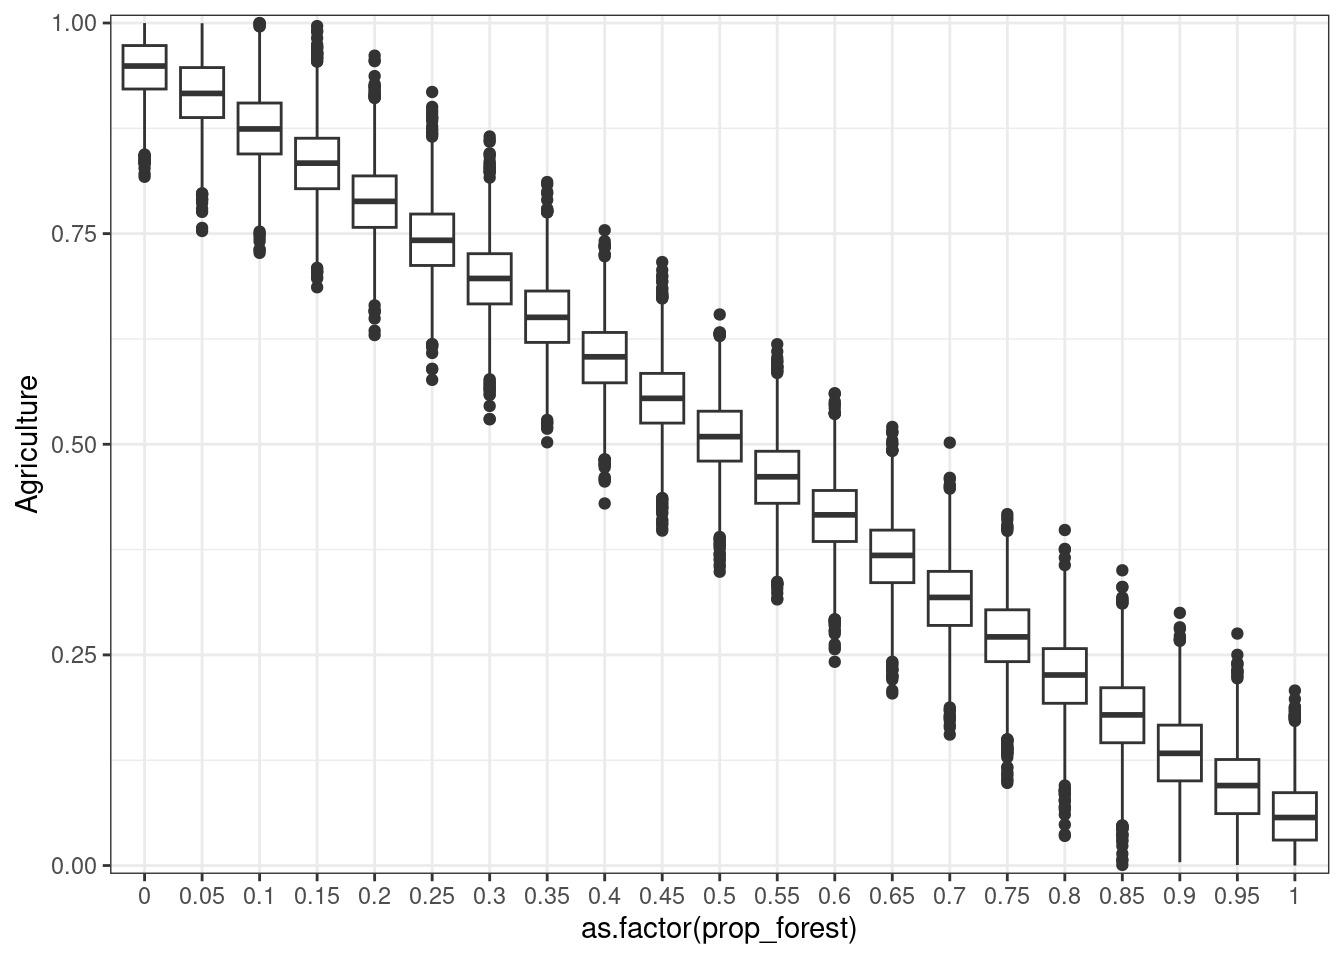

In [ ]:
ggplot(data = final_results, aes(x = as.factor(prop_forest), y = Agriculture)) +
  geom_boxplot() +
  theme_bw() +
  scale_y_continuous(expand = c(0,0.01))
